In [137]:
from functools import partial

import pandas as pd
import pygam
from pygam.terms import s, f
import numpy as np
from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_ribbon,
    theme_bw,
    theme,
    theme_matplotlib,
    facet_wrap,
    geom_hline,
)
from matplotlib import pyplot as plt
from bayes_opt import BayesianOptimization

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [138]:
df = pd.read_csv("../data/prepared_data.csv", index_col="SEQN").rename(
    {"any_caffeine.1": "any_caffeine_log"}, axis=1
)
df.head()

df["any_vig_activity"] = df["activity_vig_min"] >= 10

In [152]:
fit_data = df[
    [
        "bmi_total",
        "demo_age",
        "activity_sed_min",
        "alcohol_nmbr_drinks",
        "any_caffeine_log",
        "is_male",
        "poverty_num",
        "demo_race_str_black",
        "demo_race_str_mexican_american",
        "kidney_had_stones",
    ]
]
y = fit_data.pop("kidney_had_stones")


def gam_performance(
    x,
    y,
    bmi_total_lam,
    demo_age_lam=None,
    activity_sed_min_lam=None,
    alcohol_nmbr_drinks_lam=None,
    any_caffeine_log_lam=None,
    is_male_lam=None,
    poverty_num_lam=None,
    demo_race_str_black_lam=None,
    demo_race_str_mexican_american_lam=None,
    return_mod=False,
):

    bmi_spline = s(0, lam=bmi_total_lam)
    demo_age_spline = s(1, lam=demo_age_lam)
    activity_sed_min_spline = s(2, lam=activity_sed_min_lam)
    alcohol_nmbr_drinks_spline = s(3, lam=alcohol_nmbr_drinks_lam)
    any_caffeine_log_spline = s(4, lam=any_caffeine_log_lam)
    is_male_spline = f(5, lam=is_male_lam)
    poverty_num_spline = s(6, lam=poverty_num_lam)
    demo_race_str_black_spline = f(7, lam=demo_race_str_black_lam)
    demo_race_str_mexican_american_spline = f(8, lam=demo_race_str_mexican_american_lam)

    log_gam = pygam.LogisticGAM(
        demo_race_str_mexican_american_spline
        + demo_race_str_black_spline
        + poverty_num_spline
        + is_male_spline
        + any_caffeine_log_spline
        + alcohol_nmbr_drinks_spline
        + activity_sed_min_spline
        + demo_age_spline
        + bmi_spline
    )

    if return_mod:
        log_gam.fit(x, y)
        return log_gam

    else:

        # scorer = make_scorer(roc_auc_score, needs_proba=True)
        auc_scores = []
        for cv_set in StratifiedKFold(n_splits=10, shuffle=True).split(x, y):
            scaler = StandardScaler()
            # for cv_x, cv_y in :
            train_id, test_id = cv_set
            train_x, train_y, test_x, test_y = (
                x.iloc[train_id],
                y.iloc[train_id],
                x.iloc[test_id],
                y.iloc[test_id],
            )

            train_x = scaler.fit_transform(train_x)
            test_x = scaler.transform(test_x)
            log_gam.fit(train_x, train_y)
            cv_pred = log_gam.predict_proba(test_x)
            auc_scores.append(roc_auc_score(test_y, cv_pred))
        return np.array(auc_scores).mean()


# lambda_terms = 7*[[25, 100]]


fit_fn = partial(gam_performance, x=fit_data, y=y)
optim = BayesianOptimization(
    fit_fn, pbounds={
        "bmi_total_lam": [0.05, 10000], 
        "demo_age_lam": [0.05, 10000],
        "activity_sed_min_lam": [0.05, 10000],
        "alcohol_nmbr_drinks_lam": [0.05, 10000],
        "any_caffeine_log_lam": [0.05, 10000],
        "is_male_lam": [0.05, 10000],
        "poverty_num_lam": [0.05, 10000],
        "demo_race_str_black_lam": [0.05, 10000],
        "demo_race_str_mexican_american_lam": [0.05, 10000],
        }
)

optim.maximize(init_points=10, n_iter=50)



|   iter    |  target   | activi... | alcoho... | any_ca... | bmi_to... | demo_a... | demo_r... | demo_r... | is_mal... | povert... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6257    | 6.751e+03 | 4.953e+03 | 8.115e+03 | 5.716e+03 | 1.278e+03 | 9.131e+03 | 5.356e+03 | 7.598e+03 | 6.757e+03 |
| 2         | 0.6278    | 6.438e+03 | 7.56e+03  | 5.614e+03 | 5.778e+03 | 8.521e+03 | 5.584e+03 | 4.256e+03 | 8.922e+03 | 7.923e+03 |


In [148]:
fitted_model = gam_performance(x=fit_data, y=y, **optim.max["params"], return_mod=True)
fitted_model.summary()
# fitted_model.predict_proba(fit_data)

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       4.858
Link Function:                        LogitLink Log Likelihood:                                 -2824.4816
Number of Samples:                         9693 AIC:                                             5658.6792
                                                AICc:                                            5658.6875
                                                UBRE:                                               2.5842
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.032
Feature Function                  Lam

/var/folders/qk/w86hxqjx1sz7tb4pk4_gy8pm0000gn/T/ipykernel_18639/2771837545.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/min

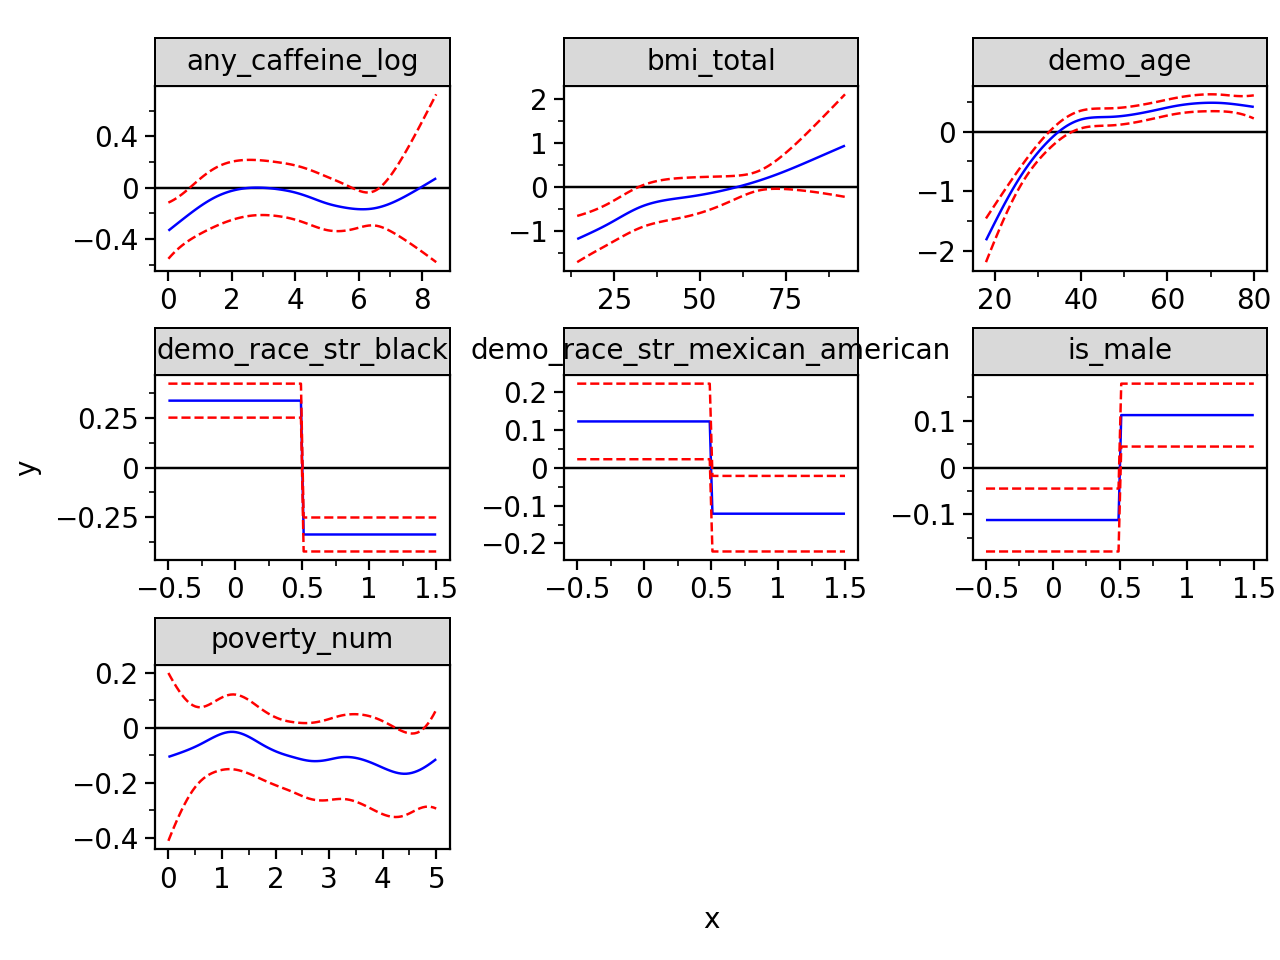

<Figure Size: (640 x 480)>

In [88]:
# plot_dfs = []
# for i, name in enumerate(fit_data.columns):
#     XX = log_gam.generate_X_grid(term=i)
#     y_vals, conf_limits = log_gam.partial_dependence(i, XX, width=0.95)
#     plot_df = pd.DataFrame(
#         {
#             "feature": name,
#             "x": XX[:, i],
#             "dep": y_vals,
#             "dep_low": conf_limits[:, 0],
#             "dep_high": conf_limits[:, 1],
#         }
#     )
#     plot_dfs.append(plot_df)

# plot_df = pd.concat(plot_dfs)


num_terms = len(log_gam.terms) - 1  # remove intercept
# fig, ax = plt.subplots(num_terms, ncols=1, sharey=False, sharex=False)

partial_dependence = []
for i, term in enumerate(log_gam.terms):
    if term.isintercept:
        continue
    XX = log_gam.generate_X_grid(term=i)
    y_vals, conf_limits = log_gam.partial_dependence(i, XX, width=0.95)
    plot_df = pd.DataFrame(
        {
            "feature": fit_data.columns[i],
            "x": XX[:, i],
            "y": y_vals,
            "low": conf_limits[:, 0],
            "high": conf_limits[:, 1],
        }
    )
    partial_dependence.append(plot_df)

partial_df = pd.concat(partial_dependence)
(
    ggplot(data=partial_df, mapping=aes(x="x", y="y"))
    + geom_hline(yintercept=0)
    + geom_line(color="blue")
    + facet_wrap("~feature", scales="free")
    + geom_line(aes(y="high"), color="red", linetype="--")
    + geom_line(aes(y="low"), color="red", linetype="--")
    + theme_matplotlib()
)

# print(y_vals, conf_limits)

# ax[i].plot(XX[:, term.feature], y_vals)
# ax[i].plot(XX[:, term.feature], conf_limits, c='r', ls='--')
# ax[i].title(f"{fit_data.columns[i]}: {repr(term)}")

# plt.show()

# print(fit_data.columns[i], i, term)

# g1 = (
#     ggplot(data=plot_df, mapping=aes(x="x", y="dep"))
#     + facet_wrap("~feature", scales="free_x", nrow=1)
#     + geom_line(color="blue")
#     + geom_line(mapping=aes(y="dep_low"), linetype="--", color="red")
#     + geom_line(mapping=aes(y="dep_high"), linetype="--", color="red")
#     + theme_bw()
#     + geom_hline(yintercept=0)
#     + theme(figure_size=(10, 4))
# )

# g1